In [1]:
# import all relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
import folium
from folium import plugins
from folium.plugins import HeatMap
from math import sin, cos, sqrt, atan2, radians
import random
import timeit

from scipy.spatial import cKDTree

# import geopy.distance

In [2]:
marburg = pd.read_pickle('../0_data/marburg_clean.pkl')
marburg_stations = pd.read_pickle('../0_data/stations/marburg_stations.pkl')

In [3]:
# we will use scikit learns BallTree to calculate the nearest station of each trips destination location
# BallTree allows us to choose haversine as a metric
# The haversine metric calculates distances of two points on a ball
from sklearn.neighbors import BallTree

# calculate the nearest station of each trip as well as the distance in km
def calc_nearest_station(trips, stations):
    R = 6373000 # approximate radius of the earth in m
    
    trips_arr = np.array(list(trips['dest']))
    stations_arr = np.array(list(stations['coordinates']))
    
    # initialize balltree with correct metric and transform our coordinates from degree to radians
    bt = BallTree(np.deg2rad(stations_arr), metric='haversine')
    # calculate the distances from every trip to the nearest station
    distances, indices = bt.query(np.deg2rad(trips_arr))
    
    # we return the distances together with the indeces of the nearest stations
    # note that we multiple the distances with the radius of the earth in kilometres
    # this is because the algorithm calculated the distances for a ball with radius 1
    return [distances*R, indices]


In [4]:
marburg.insert(0, 'it_id', range(len(marburg)))
marburg_stations.insert(0,'it_id', range(len(marburg_stations)))

In [5]:
dist, ind = calc_nearest_station(marburg, marburg_stations)

In [6]:
dist, station_it_id = calc_nearest_station(marburg, marburg_stations)
dist = pd.DataFrame(dist)[0]
station_it_id = pd.DataFrame(station_it_id)[0]
nearest_stations = pd.DataFrame({
    'near_station_dist':dist, 
    'near_station_it_id':station_it_id
})
nearest_stations.index.rename('trip_it_id', inplace=True)

In [7]:
# we create a dictionary containing the it_id as key and the real station id as value
it_id_to_station_id_dict = pd.Series(marburg_stations.index, index=marburg_stations['it_id']).to_dict()

nearest_stations['near_station_id'] = nearest_stations['near_station_it_id'].map(it_id_to_station_id_dict)

In [8]:
nearest_stations = nearest_stations.drop(['near_station_it_id'], axis=1)
marburg_stations = marburg_stations.drop(['it_id'], axis=1)

In [9]:
nearest_stations = nearest_stations.merge(right=marburg_stations, left_on='near_station_id', right_index=True)

In [10]:
nearest_stations.rename(columns={'coordinates':'near_station_coor'}, inplace=True)

In [11]:
marburg = marburg.reset_index().merge(right=nearest_stations, how='outer', left_on='it_id', right_on='trip_it_id').set_index('datetime')

In [12]:
marburg = marburg.drop(['it_id'], axis=1)

In [13]:
marburg.head(3)

,day,time,b_number,city,orig,dest,weekday,hour,trip_duration_mins,near_station_dist,near_station_id,name,near_station_coor
datetime,,,,,,,,,,,,,
2019-07-04 13:29:00,2019-07-04,13:29:00,11070,marburg,"(50.8081, 8.7754)","(50.811, 8.7742)",3,13,41,0.0,5166,Audimax,"(50.811, 8.7742)"
2019-07-06 16:53:00,2019-07-06,16:53:00,11070,marburg,"(50.7987, 8.753)","(50.8058, 8.7828)",5,16,19,0.0,5153,An den Siechengärten,"(50.8058, 8.7828)"
2019-07-06 17:18:00,2019-07-06,17:18:00,11070,marburg,"(50.8058, 8.7828)","(50.8229, 8.7747)",5,17,61,0.0,5150,Alte Kasseler Straße/Jägertunnel,"(50.8229, 8.7747)"


In [14]:
Ma_map = folium.Map(location=(50.81, 8.74), zoom_start=12, control_scale=True, max_zoom=20)

marburg_stations_list = list(marburg_stations['coordinates'])
positions = marburg_stations_list 
for index, row in marburg_stations.iterrows():
    folium.CircleMarker(radius=5, location=row.coordinates, color='black', fill_color='black', popup=row['name']).add_to(Ma_map)
    
sample = marburg.sample()
positions = [*sample.dest.values, *sample.near_station_coor.values]
colors = ['red','green']
for i,position in enumerate(positions):
    folium.CircleMarker(radius=5, location=position, color=colors[i], fill_color=colors[i]).add_to(Ma_map)
    
Ma_map

In [15]:
marburg['is_far'] = marburg['near_station_dist'].map(lambda dist : dist>300)
ma_dist_near_station = marburg.drop(marburg.columns.difference(['near_station_dist','is_far']), 1)

In [16]:
marburg_only_incorrect = marburg[marburg['is_far'] == True]

In [17]:
Ma_map = folium.Map(location=(50.81, 8.74), zoom_start=10, control_scale=True, max_zoom=20)
Ma_map.add_child(plugins.HeatMap(marburg_only_incorrect['dest'], radius=15))

for index, row in marburg_stations.iterrows():
    folium.CircleMarker(radius=5, location=row.coordinates, color='black', fill_color='black', popup=row['name']).add_to(Ma_map)

Ma_map

In [18]:
# resample the KPI hourly
ma_dist_near_station_hourly = ma_dist_near_station[ma_dist_near_station['is_far'] == True].resample('h')['is_far'].count()
ma_dist_near_station_hourly = pd.DataFrame(ma_dist_near_station_hourly)

In [19]:
# we now add some columns for weekday, date and hour, in order to visualize the KPI grouped by weekday or hour
ma_dist_near_station_hourly['weekday'] = ma_dist_near_station_hourly.index.map(lambda datetime : datetime.weekday)

day_of_week = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
ma_dist_near_station_hourly['weekday'] = ma_dist_near_station_hourly['weekday'].map(day_of_week)

ma_dist_near_station_hourly['date'] = ma_dist_near_station_hourly.index.map(lambda datetime : datetime.date)
ma_dist_near_station_hourly['hour'] = ma_dist_near_station_hourly.index.map(lambda datetime : datetime.hour)

In [30]:
# group by date and weekday and then take the sum of the bikes that are parked 'far away' from the next station
ma_dist_near_station_resample_weekday = ma_dist_near_station_hourly.groupby(['date','weekday'])['is_far'].sum()
ma_dist_near_station_resample_weekday = pd.DataFrame(ma_dist_near_station_resample_weekday)

In [31]:
# group by date and hour and then take the sum of the bikes that are parked 'far away' from the next station
ma_dist_near_station_resample_hourly = ma_dist_near_station_hourly.groupby(['date','hour'])['is_far'].sum()
ma_dist_near_station_resample_hourly = pd.DataFrame(ma_dist_near_station_resample_hourly)

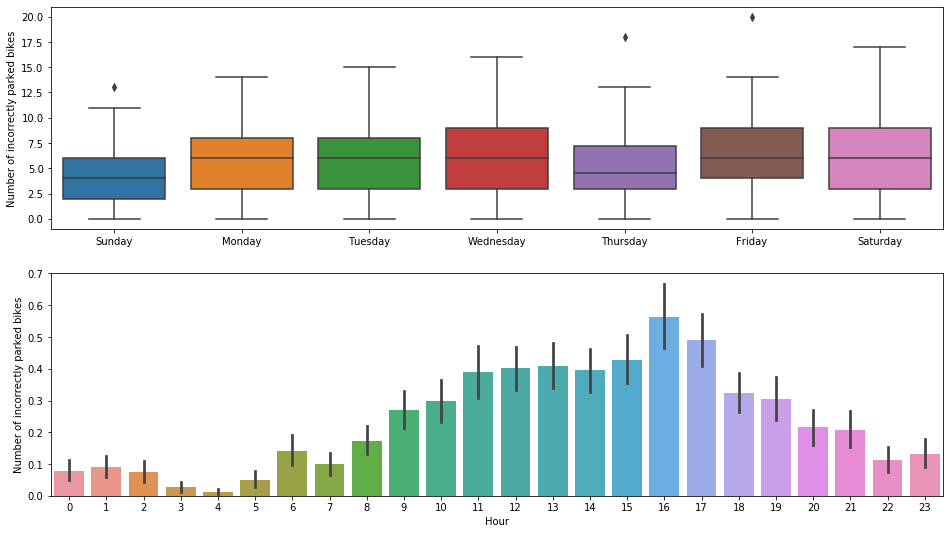

In [32]:
fig,axes = plt.subplots(nrows=2 ,figsize=(16,9)) 

sns.boxplot(x=ma_dist_near_station_resample_weekday.index.get_level_values(1), y=ma_dist_near_station_resample_weekday["is_far"],ax=axes[0])
sns.barplot(x=ma_dist_near_station_resample_hourly.index.get_level_values(1), y=ma_dist_near_station_resample_hourly["is_far"],ax=axes[1])

axes[0].set_xlabel('')
axes[1].set_xlabel('Hour')

for ax in axes:
    ax.set_ylabel('Number of incorrectly parked bikes')


plt.show()

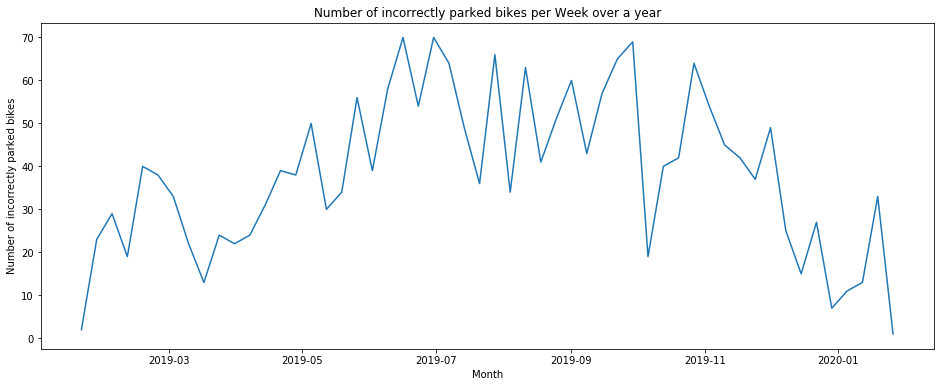

In [33]:

fig,ax = plt.subplots(figsize=(16,6))

ax.plot(ma_dist_near_station[ma_dist_near_station['is_far'] == True].resample('W')['is_far'].count())

ax.set_title('Number of incorrectly parked bikes per Week over a year')
ax.set_xlabel('Month')
ax.set_ylabel('Number of incorrectly parked bikes')

plt.show()


## Duisburg

In [36]:
duisburg = pd.read_pickle('../0_data/duisburg_clean.pkl')
duisburg_stations = pd.read_pickle('../0_data/stations/duisburg_stations.pkl')

In [37]:
duisburg.insert(0, 'it_id', range(len(duisburg)))
duisburg_stations.insert(0,'it_id', range(len(duisburg_stations)))

In [38]:
dist, station_it_id = calc_nearest_station(duisburg, duisburg_stations)
station_it_id = pd.DataFrame(station_it_id)[0]
dist = pd.DataFrame(dist)[0]
nearest_stations = pd.DataFrame({
    'near_station_it_id':station_it_id,
    'near_station_dist':dist
})
nearest_stations.index.rename('trip_it_id', inplace=True)

In [39]:
# we create a dictionary containing the it_id as key and the real station id as value
it_id_to_station_id_dict = pd.Series(duisburg_stations.index, index=duisburg_stations['it_id']).to_dict()

nearest_stations['near_station_id'] = nearest_stations['near_station_it_id'].map(it_id_to_station_id_dict)

In [40]:
nearest_stations = nearest_stations.drop(['near_station_it_id'], axis=1)
duisburg_stations = duisburg_stations.drop(['it_id'], axis=1)

In [41]:
nearest_stations = nearest_stations.merge(right=duisburg_stations, left_on='near_station_id', right_index=True)

In [42]:
nearest_stations.rename(columns={'coordinates':'near_station_coor'}, inplace=True)

In [43]:
duisburg = duisburg.reset_index().merge(right=nearest_stations, how='outer', left_on='it_id', right_on='trip_it_id').set_index('datetime')

In [47]:
duisburg = duisburg.drop(['it_id'], axis=1)

KeyError: "['it_id'] not found in axis"

In [48]:
Du_map = folium.Map(location=(51.44, 6.83), #took the middle of limits as coordinates
                       zoom_start=10, control_scale=True, max_zoom=20)

for index, row in duisburg_stations.iterrows():
    folium.CircleMarker(radius=5, location=row.coordinates, color='black', fill_color='black', popup=row['name']).add_to(Du_map)
    
sample = duisburg.sample()
positions = [*sample.dest.values, *sample.near_station_coor.values]
colors = ['red','green']
for i,position in enumerate(positions):
    folium.CircleMarker(radius=5, location=position, 
                                 color=colors[i], fill_color=colors[i]).add_to(Du_map)
    
Du_map #showing Map

In [49]:
duisburg['is_far'] = duisburg['near_station_dist'].map(lambda dist : dist>50)
du_dist_near_station = duisburg.drop(duisburg.columns.difference(['near_station_dist','is_far','dest']), 1)
du_dist_near_station

,dest,near_station_dist,is_far
datetime,,,
2019-05-27 14:48:00,"(51.4283, 6.7856)",0.000000,False
2019-05-27 17:20:00,"(51.4314, 6.7591)",0.000000,False
2019-05-28 08:19:00,"(51.4333, 6.7684)",23.301674,False
2019-06-04 09:13:00,"(51.4314, 6.7591)",0.000000,False
2019-06-05 09:08:00,"(51.4393, 6.7829)",0.000000,False
...,...,...,...
2020-01-20 07:14:00,"(51.4294, 6.7772)",0.000000,False
2020-01-20 10:08:00,"(51.4284, 6.8004)",0.000000,False
2020-01-20 19:39:00,"(51.4294, 6.7772)",0.000000,False


In [66]:
duisburg_incorrect = duisburg[duisburg['is_far'] == True]

In [68]:
Du_map = folium.Map(location=(51.44, 6.83), zoom_start=10, control_scale=True, max_zoom=20)
Du_map.add_child(plugins.HeatMap(duisburg_incorrect['dest'], radius=15))

for index, row in duisburg_stations.iterrows():
    folium.CircleMarker(radius=5, location=row.coordinates, color='black', fill_color='black', popup=row['name']).add_to(Du_map)

Du_map

In [72]:
# resample the KPI hourly
du_dist_near_station_hourly = du_dist_near_station[du_dist_near_station['is_far'] == True].resample('h')['is_far'].count()
du_dist_near_station_hourly = pd.DataFrame(du_dist_near_station_hourly)

In [73]:
# we now add some columns for weekday, date and hour, in order to visualize the KPI grouped by weekday or hour
du_dist_near_station_hourly['weekday'] = du_dist_near_station_hourly.index.map(lambda datetime : datetime.weekday)

du_dist_near_station_hourly['weekday'] = du_dist_near_station_hourly['weekday'].map(day_of_week)

du_dist_near_station_hourly['date'] = du_dist_near_station_hourly.index.map(lambda datetime : datetime.date)
du_dist_near_station_hourly['hour'] = du_dist_near_station_hourly.index.map(lambda datetime : datetime.hour)

In [74]:
# group by date and weekday and then take the sum of the bikes that are parked 'far away' from the next station
du_dist_near_station_resample_weekday = du_dist_near_station_hourly.groupby(['date','weekday'])['is_far'].sum()
du_dist_near_station_resample_weekday = pd.DataFrame(du_dist_near_station_resample_weekday)

In [75]:
# group by date and hour and then take the sum of the bikes that are parked 'far away' from the next station
du_dist_near_station_resample_hourly = du_dist_near_station_hourly.groupby(['date','hour'])['is_far'].sum()
du_dist_near_station_resample_hourly = pd.DataFrame(du_dist_near_station_resample_hourly)

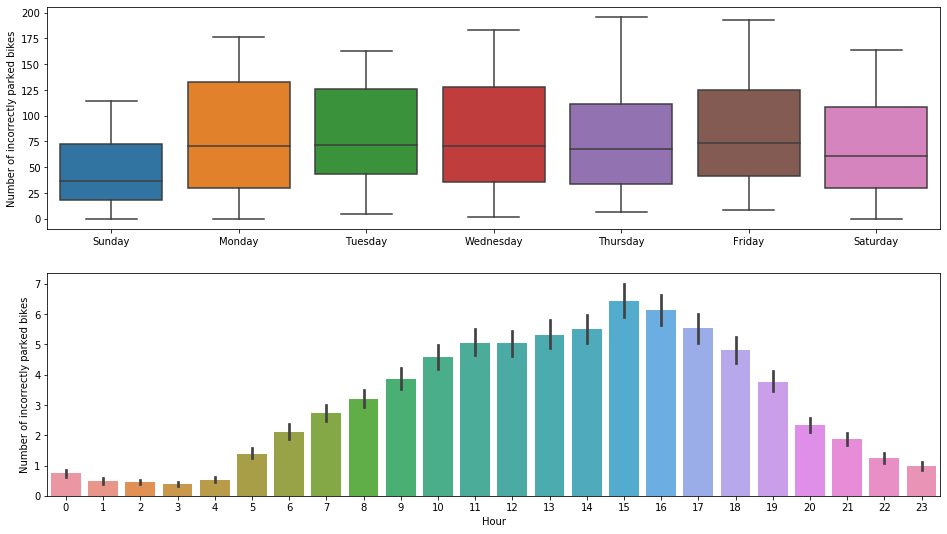

In [76]:
fig,axes = plt.subplots(nrows=2 ,figsize=(16,9)) 

sns.boxplot(x=du_dist_near_station_resample_weekday.index.get_level_values(1), y=du_dist_near_station_resample_weekday["is_far"],ax=axes[0])
sns.barplot(x=du_dist_near_station_resample_hourly.index.get_level_values(1), y=du_dist_near_station_resample_hourly["is_far"],ax=axes[1])

axes[0].set_xlabel('')
axes[1].set_xlabel('Hour')

for ax in axes:
    ax.set_ylabel('Number of incorrectly parked bikes')


plt.show()

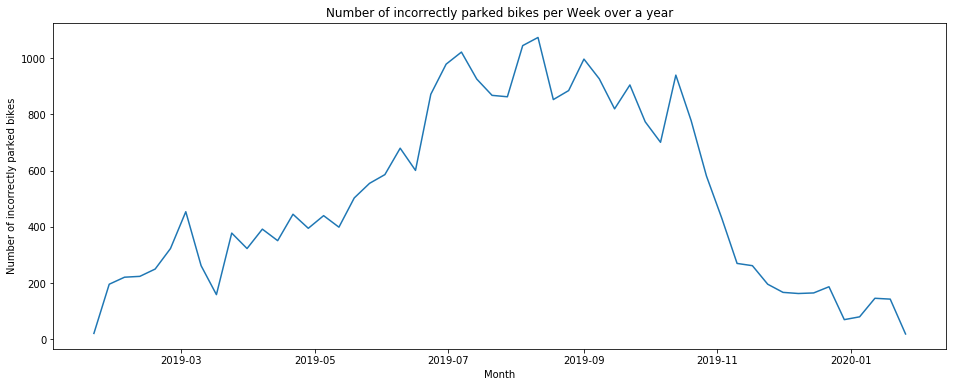

In [77]:

fig,ax = plt.subplots(figsize=(16,6))

ax.plot(du_dist_near_station[du_dist_near_station['is_far'] == True].resample('W')['is_far'].count())

ax.set_title('Number of incorrectly parked bikes per Week over a year')
ax.set_xlabel('Month')
ax.set_ylabel('Number of incorrectly parked bikes')

plt.show()
